# <center> Human-Robot Interaction: Dialogue System

# 1. Set-up

In [1]:
running_locally = True

Install the [Hugging Face Transformers](https://huggingface.co/transformers/quicktour.html) library

In [5]:
!pip -q install transformers tensorboardX

In [6]:
# accessing support files and dataset
import sys, os

if running_locally:
  sys.path.append('Support')
  sys.path.insert(0, os.path.abspath('Support'))
else:
  from google.colab import drive
  drive.mount('/content/gdrive',force_remount=True)
  sys.path.append('/content/gdrive/MyDrive/Colab/ECE4078_2021_Practicals/Week11/Support')
  sys.path.insert(1, os.path.abspath('/content/gdrive/MyDrive/Colab/ECE4078_2021_Practicals/Week11/Support'))
  !ls '/content/gdrive/MyDrive/Colab/ECE4078_2021_Practicals/Week11/Support'

# 2. Sentiment Analysis

In [7]:
# import requirements
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from helper import *

# download pretrained models (once)
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
model = AutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)
classifier = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)

Downloading:   0%|          | 0.00/953 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/638M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/851k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [8]:
# test multilingual sentiment analysis (emoji included)
results = classifier(["Goedemorgen :)",
                      "Happy to see you again!",
                      "It's horrible that we are still in lock-down :(",
                      "Too bad we are still in lock-down :(",
                      "Anyway, let's get back to the course.",
                      "Anyway, let's get back to the course :)",])

# stars: 1 = strong negative, 2 = mild negative, 3 = neutral, 4 = mild positive, 5 = strong positive
# score: confidence of the sentiment label prediction
for result in results:
    print(f"label: {result['label']}, with score: {round(result['score'], 4)}")

label: 5 stars, with score: 0.485
label: 5 stars, with score: 0.7099
label: 1 star, with score: 0.5144
label: 2 stars, with score: 0.442
label: 3 stars, with score: 0.3589
label: 4 stars, with score: 0.3472


In [9]:
# in-lecture quiz 4 answer
results = classifier(["So long, and thanks for all the fish."]) 
for result in results:
    print(f"label: {result['label']}, with score: {round(result['score'], 4)}")

label: 5 stars, with score: 0.7393


In [10]:
# post-lecture quiz 4 answer
results = classifier(["Ground Control to Major Tom, your circuit's dead, there's something wrong."])
for result in results:
    print(f"label: {result['label']}, with score: {round(result['score'], 4)}")

label: 1 star, with score: 0.434


# 3. Dialog System

A chatbot using [DialoGPT](https://github.com/microsoft/DialoGPT)

Three pre-trained models are available. Here we use the small version (117M). You can also test the medium (345M) or the large (762M) version.

In [11]:
# import requirements
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
from helper import *

# download pretrained models (once)
# other versions available: "microsoft/DialoGPT-medium" and "microsoft/DialoGPT-large"
tokenizer = AutoTokenizer.from_pretrained("microsoft/DialoGPT-small")
model = AutoModelForCausalLM.from_pretrained("microsoft/DialoGPT-small")

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/641 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/0.99M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/335M [00:00<?, ?B/s]

An example output with history flag set to True (used a different seed):

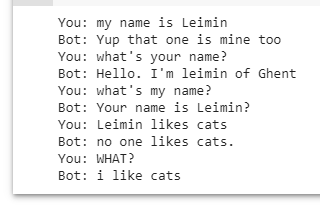

An example output with history flag set to False (used a different seed):

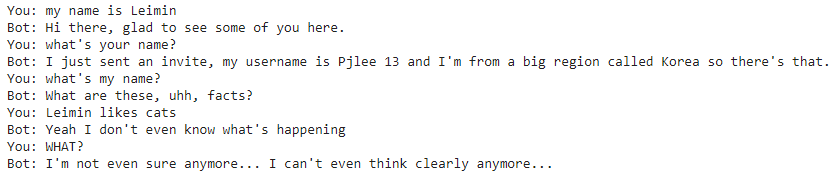

In [12]:
# dialogue system using DialoGPT

history = True # toggle whether to include dialog history or not
fixed = True # toggle whether or not you want the bot to generate the same response for the same output
n_turns = 5 # number of user inputs (turns)

# set a random seed if you want the bot to generate the same response for the same output
if fixed:
    set_seed(1234)

# Let's chat
for step in range(n_turns):
    # encode user input
    user_input = input("You: ")
    new_user_input_ids = tokenizer.encode(user_input + tokenizer.eos_token, return_tensors='pt')

    # append the new input to the chat history and respond to the whole history
    if history:
        bot_input_ids = torch.cat([chat_history_ids, new_user_input_ids], dim=-1) if step > 0 else new_user_input_ids
    # only respond to the current input
    else:
        bot_input_ids = new_user_input_ids

    # generate a response
    # total chat history limited to 1000 tokens
    # top_k: the k=50 most likely next words are filtered and the probability mass is redistributed among them
    # top_p: picks the minimum number of words to exceed together p=95% of the probability mass
    # more about different generation methods: https://huggingface.co/blog/how-to-generate  
    chat_history_ids = model.generate(
        bot_input_ids,
        do_sample=True, 
        max_length=1000,
        top_k=50, 
        top_p=0.95,
        pad_token_id=tokenizer.eos_token_id
    )
    
    # print bot response
    print("Bot: {}".format(tokenizer.decode(chat_history_ids[:, bot_input_ids.shape[-1]:][0], 
                                            skip_special_tokens=True)))

You: I heard the semester is almost over
Bot: Why have a finals week if you know you're only gonna be in for one extra semester anyway
You: you should get back to study
Bot: I had it in class but did not finish. My next exam will be a midterm exam, can't wait to read through these
You: no, your next exam would be a final exam
Bot: i took it the day before my exam
You: next week
Bot: what exam will you go for?
You: I forgot
Bot: I haven't done it yet!
